In [7]:
import matplotlib.pyplot as plt
from cmtj import Junction, Layer, CVector, constantDriver
import numpy as np
import pandas as pd


# sphere points
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0 : 2.0 * pi : 100j]
x = r * sin(phi) * cos(theta)
y = r * sin(phi) * sin(theta)
z = r * cos(phi)

data = {}
demagTensor = [CVector(0.0, 0.0, 0.0), CVector(0.0, 0.0, 0.0), CVector(0.0, 0.0, 1.0)]

damping = 0.1
currentDensity = 1e10
beta = 0.9
spinPolarisation = 1.0

l1 = Layer.createSTTLayer(
    id="free",
    mag=CVector(1.0, 1.0, 0.1),
    anis=CVector(1, 0.0, 0.0),
    Ms=1,
    thickness=10e-9,
    cellSurface=(10e-9 * 10e-9),
    demagTensor=demagTensor,
    damping=damping,
    SlonczewskiSpacerLayerParameter=1.0,
    spinPolarisation=spinPolarisation,
    beta=beta,
)

l1.setReferenceLayer(CVector(1, 0.0, 0.0))
junction = Junction([l1], 100, 200)
dt = 1e-13
# junction.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(350e3))
# current driver

junction.setLayerCurrentDriver("free", constantDriver(-currentDensity))
k = 10
for t in (10, 100, 300, 600):
    junction.clearLog()
    junction.setLayerTemperatureDriver("free", constantDriver(t))

    junction.runSimulation(15e-9, dt, dt, False, False)

    log = junction.getLog()
    mx, my, mz = log["free_mx"], log["free_my"], log["free_mz"]
    mtheta, mphi = np.arccos(mz), np.arctan2(my, mx)
    pd.DataFrame(
        {
            "mx": mx[::k],
            "my": my[::k],
            "mz": mz[::k],
            "theta": np.rad2deg(mtheta)[::k],
            "phi": np.rad2deg(mphi)[::k],
            "time": log["time"][::k],
            "R": log["R"][::k],
        }
    ).to_csv(f"./docs/data/logTemp_{t}K.csv", index=False, sep=",")

[WARNING] Solver automatically changed to Euler Heun for stochastic calculation.
[WARNING] Solver automatically changed to Euler Heun for stochastic calculation.
[WARNING] Solver automatically changed to Euler Heun for stochastic calculation.
[WARNING] Solver automatically changed to Euler Heun for stochastic calculation.


In [56]:
from cmtj.llgb import MFAWeissCurie
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd

me = 0.2

scans = defaultdict(list)
Tsrange = np.linspace(1, 1000, 200)
for J0 in (1.0e-20, 2.0e-20, 3e-20):
    for Ts in Tsrange:
        res = MFAWeissCurie(me, Ts, J0)
        est = res[0]
        scans["J0"].append(J0)
        scans["Ts"].append(Ts)
        scans["me"].append(res[0])

pd.DataFrame.from_dict(scans).to_csv("./docs/data/mfa.csv", index=False, sep=",")

In [51]:
import matplotlib.pyplot as plt
from cmtj import Junction, Layer, CVector, constantDriver
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt
from cmtj import CVector, Layer, Junction
from itertools import repeat


r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0 : 2.0 * pi : 100j]
x = r * sin(phi) * cos(theta)
y = r * sin(phi) * sin(theta)
z = r * cos(phi)


def plot_trajectories(log: Dict[str, List[float]], title: str):
    with plt.style.context(["science", "no-latex"]):
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(1, 2, 1, projection="3d")
        m = np.asarray([log["free_mx"], log["free_my"], log["free_mz"]])
        ax.plot3D(m[0], m[1], m[2], color="blue")
        ax.set_axis_off()
        ax.plot_surface(
            x, y, z, rstride=2, cstride=2, color="c", alpha=0.3, linewidth=0.1
        )
        ax.scatter([0], [0], [1], color="crimson", alpha=1.0, s=50)
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(np.asarray(log["time"]) * 1e9, log["R_free_bottom"])
        ax2.set_xlabel("Time [s]")
        ax2.set_ylabel("Resistance [Ohm]")
        fig.suptitle(title)
        fig.tight_layout()


demagTensor = [CVector(0.0, 0.0, 0.0), CVector(0.0, 0.0, 0.0), CVector(0.0, 0.0, 1.0)]

damping = 0.3
currentDensity = 4e9
beta = 1
spinPolarisation = 1.0

l1 = Layer.createSTTLayer(
    id="free",
    mag=CVector(0.0, 0.0, 1.0),
    anis=CVector(0, 0.0, 1.0),
    Ms=1.0,
    thickness=1.4e-9,
    cellSurface=7e-10 * 7e-10,
    demagTensor=demagTensor,
    damping=damping,
    SlonczewskiSpacerLayerParameter=1.0,
    spinPolarisation=spinPolarisation,
    beta=beta,
)
l2 = Layer(
    id="bottom",
    mag=CVector(0.0, 1.0, 1.0),
    anis=CVector(0, 1.0, 1.0),
    Ms=1.2,
    thickness=3e-9,
    cellSurface=7e-10 * 7e-10,
    demagTensor=demagTensor,
)

l1.setReferenceLayer(CVector(0, 1.0, 1.0))
junction = Junction([l1, l2], 100, 200)

junction.setLayerAnisotropyDriver("free", constantDriver(350e3))
junction.setLayerAnisotropyDriver("bottom", constantDriver(1500e3))
junction.setIECDriver("free", "bottom", constantDriver(-2.5e-6))
# current driver
junction.runSimulation(50e-9, 1e-13, 1e-13, False, False)
data = defaultdict(list)
current_dens = np.arange(3, 15, 2) * 1e9
for cden in tqdm(current_dens):
    junction.clearLog()
    junction.setLayerCurrentDriver("free", constantDriver(-cden))

    junction.runSimulation(150e-9, 1e-13, 1e-13, False, False)
    log = junction.getLog()

    R = np.asarray(log["R_free_bottom"])
    start_time = 10e-9
    indx = np.argwhere(np.asarray(log["time"]) > start_time).ravel()
    R = R[indx]
    y = np.fft.fft(R)
    N = len(y)
    f = np.fft.fftfreq(N, d=1e-13)
    y = np.abs(y[: N // 2])
    f = f[: N // 2]
    findx = np.argwhere((f > 1) & (f < 50e9)).ravel()
    f = f[findx]
    y = y[findx]
    data["current_density"].extend(repeat(cden, len(f)))
    data["frequencies"].extend(f)
    data["amplitudes"].extend(y)


# plot_trajectories(log, title="STO with STT on")
# with plt.style.context(["science", "no-latex"]):
#     fig, ax = plt.subplots(dpi=200)
#     ax.plot(f / 1e9, y)
#     ax.set_xlabel("Frequency [GHz]")
#     ax.set_ylabel("Amplitude")
#     # fig.tight_layout()
#     ax.set_yscale("log")
#     ax.set_xscale("log")


pd.DataFrame.from_dict(data).to_csv(
    "./docs/data/fft_oscillator.csv", index=False, sep=","
)

100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


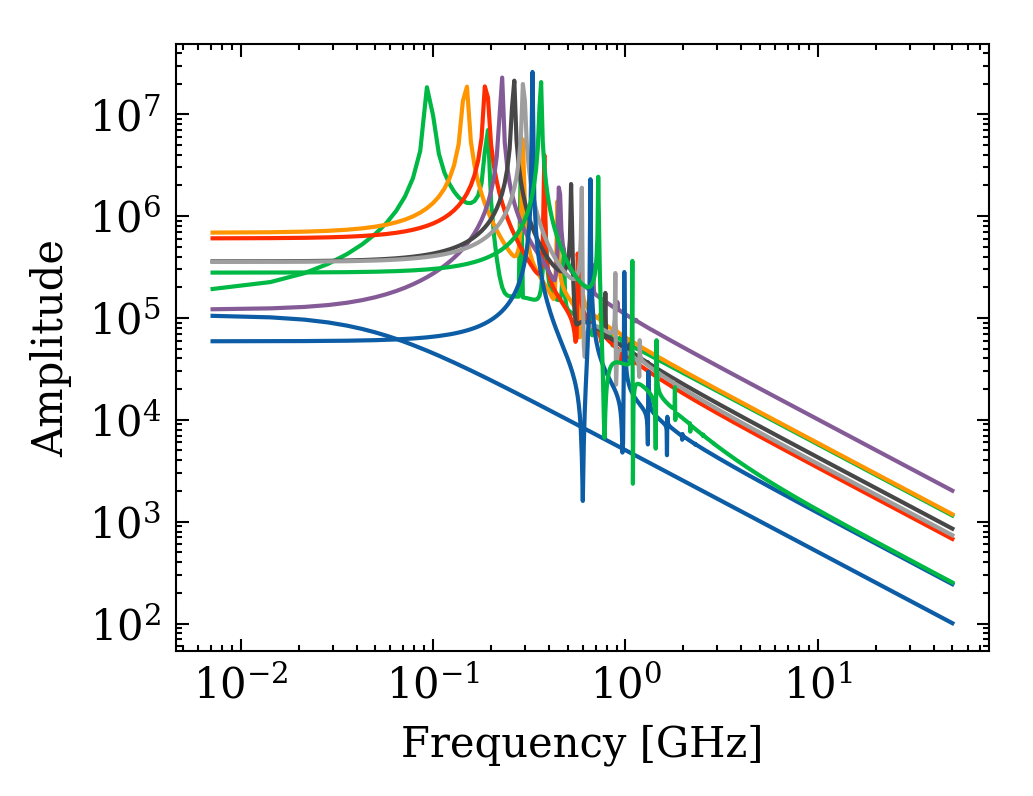

In [40]:
# import colormap
import matplotlib.cm as cm

# create a color palette
palette = plt.get_cmap("inferno")


with plt.style.context(["science", "no-latex"]):
    fig, ax = plt.subplots(dpi=300)
    for i, cden in enumerate(current_dens):
        ax.plot(
            data["frequencies"][i] / 1e9, data["amplitudes"][i], label=f"{cden/1e9}G"
        )
    # ax.plot(f / 1e9, y)
    ax.set_xlabel("Frequency [GHz]")
    ax.set_ylabel("Amplitude")
    # fig.tight_layout()
    ax.set_yscale("log")
    ax.set_xscale("log")